In [10]:
import time
import warnings

import numpy as np
from numpy.linalg import norm

import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

from sklearn.model_selection import LeaveOneOut

from pyROMs import POD, DMD, PartitionedDMD
from readers import NeutronicsDatasetReader

from utils import *

warnings.filterwarnings("ignore")

Define Routines

In [11]:
def model_validation(dataset, pod, n_splits=5, interior_only=True,
                     vars=None, shuffle=True, random_state=None):
    """
    Perform model validation before implementing the ROM.

    Parameters
    ----------
    dataset : NeutronicsDatasetReader
        The dataset reader containing the data.
    pod : POD
        The POD model with the appropriate hyper-parameters.
    n_splits : int, default 5
        The number of splits for the cross-validation study.
    interior_only : bool, default False
        A flag to include only interior values in the validation set.
    vars : str, default None
        The variables to include in the study.
    shuffle : bool, default True
        Flag for shuffling the data.
    random_state : int, default None
        Random seed to use for shuffling.
    """
    # Get the data
    X = dataset.create_dataset_matrix(vars)
    Y = dataset.parameters

    # Initialize cross-validator
    loo = LeaveOneOut()
    if interior_only:
        interior = dataset.interior_map
        iterator = loo.split(X[interior], Y[interior])
    else:
        iterator = loo.split(X, Y)

    # Run leave-one-out study
    errors = []
    for train, test in iterator:
        if interior_only:
            X_train, Y_train = X[interior][train], Y[interior][train]
            X_test, Y_test = X[interior][test], Y[interior][test]
            X_train = np.vstack((X_train, X[dataset.boundary_map]))
            Y_train = np.vstack((Y_train, Y[dataset.boundary_map]))
        else:
            X_train, Y_train = X[train], Y[train]
            X_test, Y_test = X[test], Y[test]

        pod.fit(X_train, Y_train)
        X_pod = pod.predict(Y_test)

        error = norm(X_test[0] - X_pod[0]) / norm(X_test[0])
        errors.append(error)

    # Fit to all data
    t_start = time.time()
    pod.fit(X, Y)
    t_end = time.time()

    # Print statistics
    print()
    print(f"*** Summary of LOO Validation ***")
    print(f"{'Average Error:':<20}\t{np.mean(errors):.3e}")
    print(f"{'Maximum Error:':<20}\t{np.max(errors):.3e}")
    print(f"{'Minimum Error:':<20}\t{np.min(errors):.3e}")

    print()
    print(f"ROM Construction Time:\t{t_end - t_start:.3e} s")


def excercise_rom(pod, distribution,
                  qoi_function, n_samples=int(2e4)):
    """
    Excercise the ROM for QoI `qoi_function` with `n_samples`.

    Parameters
    ----------
    pod : POD
    distribution : dict
        Dictionary containing the distribution type, and arguments
        that describe it.
    qoi_function : callable
    n_samples : int, default 20,000

    Returns
    -------
    ndarray (n_samples,)
    """
    # Generate samples
    rng = np.random.default_rng()
    if distribution["type"] == "uniform":
        if "bounds" not in distribution:
            raise ValueError(f"Uniform distributions must take have "
                             f"accompanying low and high bounds.")

        # Get and check distribution args
        bounds = distribution["bounds"]
        if len(bounds) != pod.n_parameters:
            raise ValueError("Parameter bounds must be specified for "
                             "each parameter of the POD ROM.")
        for p in range(len(bounds)):
            if len(bounds[p]) != 2:
                raise ValueError(
                    "Parameter bounds must be specified as [low, high].")

        # Generate samples
        samples = np.empty((n_samples, pod.n_parameters))
        for p in range(pod.n_parameters):
            low, high = bounds[p][0], bounds[p][1]
            samples[:, p] = rng.uniform(low, high, n_samples)

    else:
        raise NotImplementedError("Other distributions not implemented.")

    # Make predictions asbout QoI
    print("Starting ROM queries...")
    qoi = np.zeros(n_samples)

    t_start = time.time()
    X_pod = pod.predict(samples)
    for s in range(n_samples):
        qoi[s] = qoi_function(X_pod[s])
    t_end = time.time()
    print(f"ROM queries took {t_end - t_start:.3e} s.")
    print(f"Mean QoI:\t{np.mean(qoi):.3e}")
    print(f"STD QoI:\t{np.std(qoi):.3e}")
    return qoi


def plot_bounding_cases(dataset, qoi_function):
    """
    Plot the bounding cases for the parameter space.

    Parameters
    ----------
    dataset : NeutronicsDatasetReader
    vars : str, default None
    """
    peak_power = []
    for s in range(len(dataset.simulations)):
        simulation = dataset.simulations[s]
        P_max = np.max(simulation.powers)
        peak_power.append(P_max)

    plt.figure()
    plt.tick_params(labelsize=12)
    plt.xlabel("Time (s)", fontsize=14)
    plt.ylabel("Power (W)", fontsize=14)

    styles = ["-*b", "-or"]
    argmin = int(np.argmin(peak_power))
    argmax = int(np.argmax(peak_power))
    for i, s in enumerate([argmax, argmin]):
        simulation = dataset.simulations[s]
        P = simulation.powers
        plt.plot(dataset.times, P, styles[i])
        qoi = qoi_function(simulation.power_densities)
        print(f"QoI:\t{qoi:.3e}")
    plt.grid(True)
    plt.tight_layout()


def plot_distribution(qoi, xlabel=None):
    """
    Plot the QoI distribution.

    Parameters
    ----------
    qoi : numpy.ndarray
        The QoIs from the ROM.
    """
    xlabel = "QoI" if xlabel is None else xlabel

    fig: Figure = plt.figure()
    ax: Axes = fig.add_subplot(1, 1, 1)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
    sb.histplot(qoi, bins=20, stat='probability', kde=True,
                log_scale=False, ax=ax)
    plt.tight_layout()


def print_statistics_table(qoi):
    """
    Print a table containing the distribution statistics.

    Parameters
    ----------
    qoi : numpy.ndarray
    """
    conf = np.percentile(qoi, [2.5, 97.5])
    msg = "\\begin{tabular}{c|c}"
    msg += "\n\t \\textbf{Quantity} & \\textbf{Value} \\\\ \hline"
    msg += f"\n\t Mean & {np.mean(qoi):.3e} \\\\"
    msg += f"\n\t Median & {np.median(qoi):.3e} \\\\"
    msg += f"\n\t Std. Deviation & {np.std(qoi):.3e} \\\\"
    msg += f"\n\t 95\% Conf. Interval & [{conf[0]:.3e}, {conf[1]:.3e}] \\\\"
    msg += "\n\end{tabular}"
    print(msg)


Parse the Data

In [12]:
problem_name = input("What problem? ")

print("Loading and formating the data...")
t_start = time.time()
dataset = get_data(problem_name)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")


Loading and formating the data...
Loading the data took 17.294995 s


Performing Model Validation

In [7]:
interior_only = True

params = get_params(problem_name)
vars = params["vars"]
svd_rank = 1.0 - params["tau"]
interp = params["interp"]
epsilon = params["epsilon"]

pod = POD(svd_rank, interp, epsilon)
res = model_validation(dataset, pod, vars=vars)



*** Summary of LOO Validation ***
Average Error:      	5.464e-03
Maximum Error:      	8.497e-03
Minimum Error:      	2.473e-03

ROM Construction Time:	3.930e-02 s


Generate Random Samples and Query the ROM


QoI:	3.837e+00
QoI:	1.499e+00
Starting ROM queries...
ROM queries took 3.215e+00 s.
Mean QoI:	2.248e+00
STD QoI:	4.609e-01


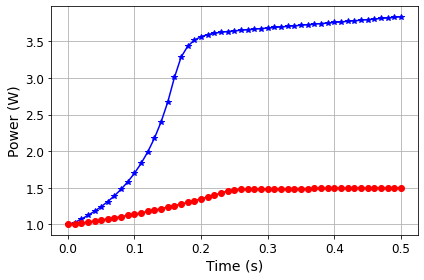

In [8]:
if 'sphere' in problem_name:
    dmd = DMD(svd_rank=4)
    dt = np.diff(dataset.times)[0]
    def QoI(x):
        if x.ndim == 1:
            x = dataset.unstack_simulation_vector(x)[0]
        dmd.fit(x)
        omegas = np.log(dmd.eigvals)/dt
        return omegas[np.argmax(omegas.real)]

elif 'slab' in problem_name:
    def QoI(x):
        if x.ndim == 1:
            x = dataset.unstack_simulation_vector(x)[0]
        return np.sum(x[-1]) * 2.0

elif 'twigl' in problem_name:
    def QoI(x):
        if x.ndim == 1:
            x = dataset.unstack_simulation_vector(x)[0]
        return np.sum(x[-1]) * 4.0**2

elif 'lra' in problem_name:
    def QoI(x):
        if x.ndim == 1:
            x = dataset.unstack_simulation_vector(x)[0]
        x = x[np.argmax(np.sum(x, axis=1))]
        return np.sum(x) * 7.5**2

plot_bounding_cases(dataset, QoI)

dinfo = {"type": "uniform",
         "bounds": dataset.parameter_bounds}
qoi = excercise_rom(pod, dinfo, QoI, n_samples=20000)


Plot the Distribution

\begin{tabular}{c|c}
	 \textbf{Quantity} & \textbf{Value} \\ \hline
	 Mean & 2.248e+00 \\
	 Median & 2.177e+00 \\
	 Std. Deviation & 4.609e-01 \\
	 95\% Conf. Interval & [1.528e+00, 3.271e+00] \\
\end{tabular}


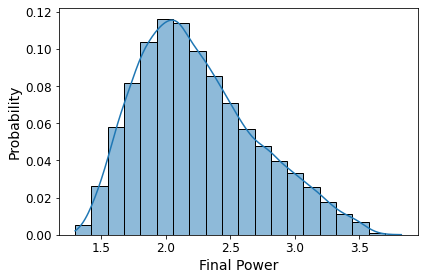

In [9]:
if 'sphere' in problem_name:
    qoi_name = "$\\alpha_0"
elif 'slab' in problem_name or 'twigl' in problem_name:
    qoi_name = "Final Power"
elif 'lra' in problem_name:
    qoi_name = "Peak Power"
plot_distribution(qoi, qoi_name)

print_statistics_table(qoi)
